## Dynamic Adjusted System for Campaign Effectiveness

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. **Question Interpretation**


**What is the purpose of this System**
We have tried various approach to deal with this answer. Initially, we thought that we should simply dynamically adjust our offer to the customer based on the `outcome` from the `campaign_data`. However, we realize that this is no difference between building a recommendation engine. Then, what shall we do?
1. First, we tried building a rule-based strategy. With an event trigger system, we direct customer to various product based on their incoming transaction and app_interaction_data. However, due to the lack of app_interaction_data, we were unable to simulate our system and determine its influence on campaign_effectiveness
2. As I started on building machine learning pipeline using diagram, I realized that most of the campaign offer adjustment action in my original multi-arm bandit model was too intuitive (people would definitely be attracted by a cashback with lower spending threshold, etc.) The main part of our system is still similar to recommendation engine (Event Trigger System)
3. Then, How are we able to connect other system with building a dynamically campaign strategy?
- We realized that segmentation system has already done the work for us in personalization
- Recommendation System has already helped us identified recommended product based on customer's segmentation
- To dynamically adjust the campaign strategy, we notice the keyword **campaign effectiveness**
- We realize that the ultimate purpose is to let customers to be able to converted by our campaign. 
- Therefore, we built an entire new rule

**Campaign Pipeline**
- We separate our campaign into three types: retention, consideration, conversion. Customers who are alerted by Early Warning System is then offering with the **retention campaign** - CashBack. Customers who are not alerted - are input into the recommendation system to find out what kind of products they have. For customer who are offering with basic product: `credit_card`, `saving_accounts`, we consider we provide them **consideration campaign**. For customer who are offering products other than basic products, we consider this as **conversion campaign**.
- Ideally, the campaign system would then update campaign dataset, which records the campaign a customer is currently involved in.
- **We will try to incorporate our AIMarketing System into our entire campaign system in the future**

**Where is the dynamic Campaign**
- With a campaign dataset recording campaign of customer, and a campaign_log dataset record the campaign parameters, we realize that we can increase our campaign effectiveness by using real-time evaluated metric: **engagement score**
- By using a multi-arm bandit model adjusting the timing, frequency, and channel, we realize a dynamic campaign strategy

**Where is the dynamic part**
- Our Campaign Strategy assumed that every day, EWS(`Early Warning System`) would run through entire customer demographic dataset, to see if anyone is alerted, this allow real-time **retention campaign**
- We also assumed that every week, `Segmentation System` would update the demographic dataset regarding its segmentation, so that we allow real-time **campaign** occur
- **the most important part is that we allow our optimizer dynamically adjust the timing, frequency, and channel based on the real-time evaluation metric**

### 2. **Model Implementation**
- we tried engagement score to be a weighted sum of conversion rate and click through rate
- the model tries to incorporate customer feature using dot product to allow model adjust based on customer feature
#### **Original Dynamic Model**

In [ ]:

class ModifiedBanditWithSGD:
    def __init__(self, n_arms, learning_rate=0.01, conversion_weight=0.7, clickthrough_weight=0.3):
        self.n_arms = n_arms
        self.preferences = np.zeros(n_arms)
        self.context_weights = np.random.rand(n_arms, 10)  # Initial weights for customer features
        self.learning_rate = learning_rate
        self.conversion_weight = conversion_weight
        self.clickthrough_weight = clickthrough_weight

    def select_arm(self, customer_features):
        customer_features = np.asarray(customer_features, dtype=np.float64)
        context_scores = np.dot(self.context_weights, customer_features)
        exp_scores = np.exp(context_scores - np.max(context_scores))  # Numerical stability
        probabilities = exp_scores / np.sum(exp_scores)

        if np.any(np.isnan(probabilities)) or np.sum(probabilities) == 0:
            probabilities = np.ones(self.n_arms) / self.n_arms  # Assign uniform probabilities if needed

        return np.random.choice(self.n_arms, p=probabilities)

    def update(self, chosen_arm, customer_features, conversion_rate, clickthrough_rate):
        customer_features = np.asarray(customer_features, dtype=np.float64)
        reward = (self.conversion_weight * conversion_rate) + (self.clickthrough_weight * clickthrough_rate)
        gradient = reward - np.dot(self.context_weights[chosen_arm], customer_features)
        self.context_weights[chosen_arm] += self.learning_rate * gradient * customer_features
        np.clip(self.context_weights[chosen_arm], 0, 1, out=self.context_weights[chosen_arm])


#### **Model Simulation**
- due to lack of real-time data, we tried synthetic data instead
- for simplicity, we incorporate all features needed into one dataset instead of building a database

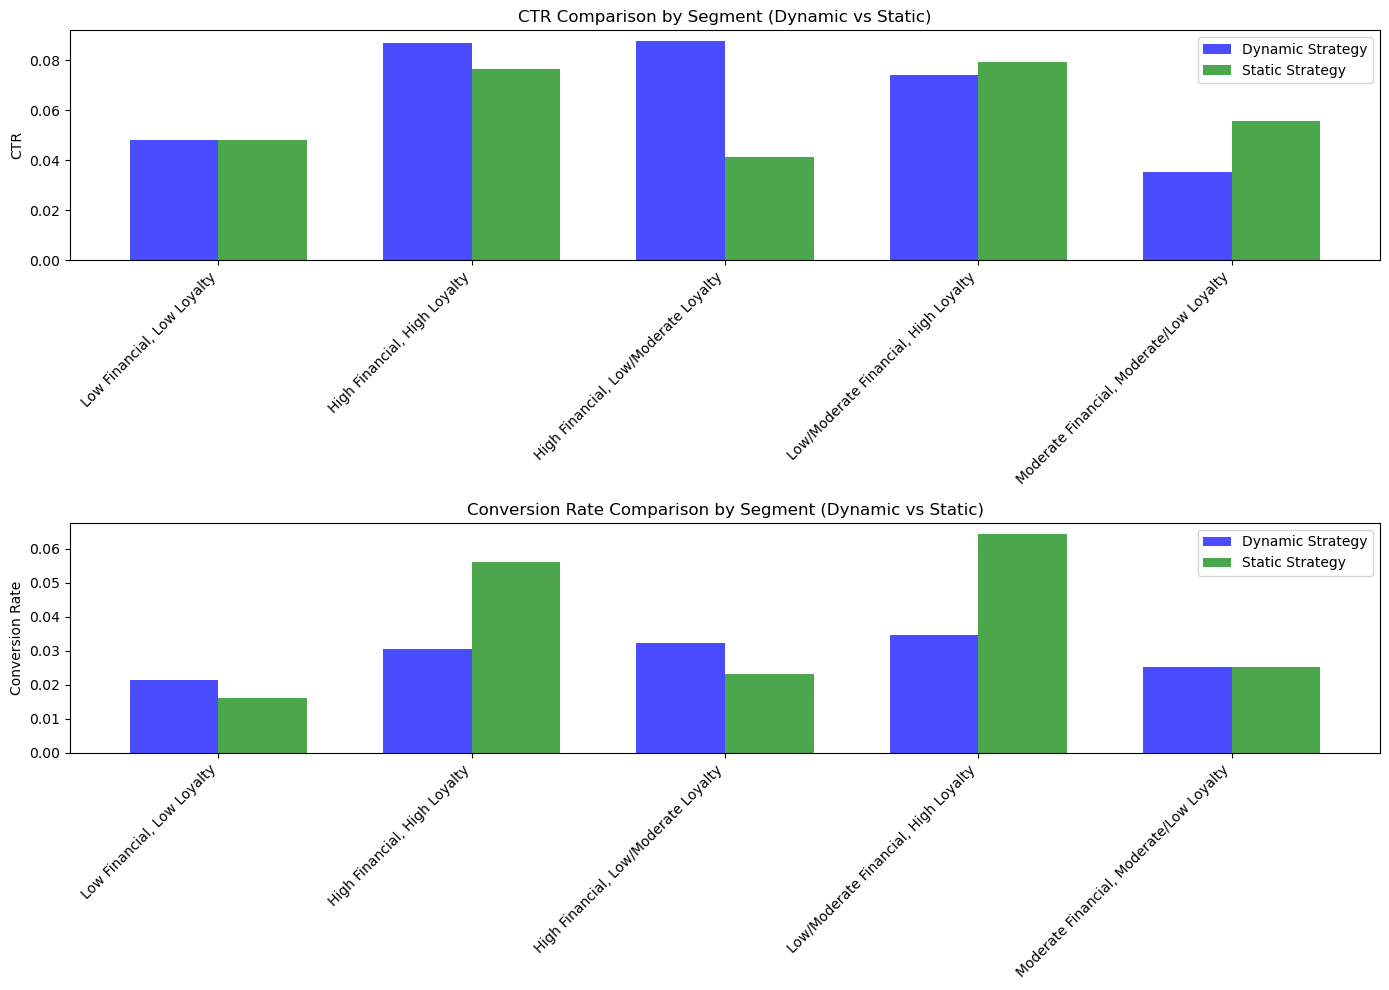

In [ ]:
# Generate synthetic customer data
def generate_customer_data(num_customers, num_features=10):
    return np.random.rand(num_customers, num_features)

# Initialize bandit models for timing, frequency, and channel
timing_options = ['Morning', 'Afternoon', 'Evening']
frequency_options = ['Once per week', 'Twice per week', 'Daily']
channel_options = ['Email', 'SMS', 'App Notification']

timing_model = ModifiedBanditWithSGD(len(timing_options))
frequency_model = ModifiedBanditWithSGD(len(frequency_options))
channel_model = ModifiedBanditWithSGD(len(channel_options))

# Simulate customer data and preferences
num_customers = 1000
customer_data = generate_customer_data(num_customers)

segments = [
    'Low Financial, Low Loyalty',
    'High Financial, High Loyalty',
    'High Financial, Low/Moderate Loyalty',
    'Low/Moderate Financial, High Loyalty',
    'Moderate Financial, Moderate/Low Loyalty'
]

segment_preferences = {
    'Low Financial, Low Loyalty': {'timing': 0.8, 'frequency': 0.5, 'channel': 0.6},
    'High Financial, High Loyalty': {'timing': 0.95, 'frequency': 0.85, 'channel': 0.9},
    'High Financial, Low/Moderate Loyalty': {'timing': 0.75, 'frequency': 0.6, 'channel': 0.7},
    'Low/Moderate Financial, High Loyalty': {'timing': 0.85, 'frequency': 0.75, 'channel': 0.8},
    'Moderate Financial, Moderate/Low Loyalty': {'timing': 0.65, 'frequency': 0.55, 'channel': 0.6}
}

segment_results_combined = {segment: {'clicks': 0, 'conversions': 0, 'total_impressions': 0} for segment in segments}
segment_results_static = {segment: {'clicks': 0, 'conversions': 0, 'total_impressions': 0} for segment in segments}

customer_segments = np.random.choice(segments, num_customers)

# Run A/B test simulation
for i, customer_features in enumerate(customer_data):
    segment = customer_segments[i]
    preferences = segment_preferences[segment]

    # Dynamic Strategy
    chosen_timing_dynamic = timing_model.select_arm(customer_features)
    chosen_frequency_dynamic = frequency_model.select_arm(customer_features)
    chosen_channel_dynamic = channel_model.select_arm(customer_features)

    conversion_rate_dynamic = np.random.rand() < preferences['timing'] * 0.05
    clickthrough_rate_dynamic = np.random.rand() < preferences['channel'] * 0.1

    timing_model.update(chosen_timing_dynamic, customer_features, conversion_rate_dynamic, clickthrough_rate_dynamic)
    frequency_model.update(chosen_frequency_dynamic, customer_features, conversion_rate_dynamic, clickthrough_rate_dynamic)
    channel_model.update(chosen_channel_dynamic, customer_features, conversion_rate_dynamic, clickthrough_rate_dynamic)

    segment_results_combined[segment]['total_impressions'] += 1
    if clickthrough_rate_dynamic:
        segment_results_combined[segment]['clicks'] += 1
    if conversion_rate_dynamic:
        segment_results_combined[segment]['conversions'] += 1

    # Static Strategy
    static_timing = 'Afternoon'
    static_frequency = 'Once per week'
    static_channel = 'Email'

    conversion_rate_static = np.random.rand() < preferences['timing'] * 0.04
    clickthrough_rate_static = np.random.rand() < preferences['channel'] * 0.09

    segment_results_static[segment]['total_impressions'] += 1
    if clickthrough_rate_static:
        segment_results_static[segment]['clicks'] += 1
    if conversion_rate_static:
        segment_results_static[segment]['conversions'] += 1

# Calculate CTR and Conversion Rate for each segment
comparison_data = {
    'Segment': segments,
    'Dynamic CTR': [],
    'Dynamic Conversion Rate': [],
    'Static CTR': [],
    'Static Conversion Rate': []
}

for segment in segments:
    impressions_dynamic = segment_results_combined[segment]['total_impressions']
    if impressions_dynamic > 0:
        ctr_dynamic = segment_results_combined[segment]['clicks'] / impressions_dynamic
        conversion_rate_dynamic = segment_results_combined[segment]['conversions'] / impressions_dynamic
    else:
        ctr_dynamic = 0
        conversion_rate_dynamic = 0

    impressions_static = segment_results_static[segment]['total_impressions']
    if impressions_static > 0:
        ctr_static = segment_results_static[segment]['clicks'] / impressions_static
        conversion_rate_static = segment_results_static[segment]['conversions'] / impressions_static
    else:
        ctr_static = 0
        conversion_rate_static = 0

    comparison_data['Dynamic CTR'].append(ctr_dynamic)
    comparison_data['Dynamic Conversion Rate'].append(conversion_rate_dynamic)
    comparison_data['Static CTR'].append(ctr_static)
    comparison_data['Static Conversion Rate'].append(conversion_rate_static)

# Create DataFrame for comparison
comparison_df = pd.DataFrame(comparison_data)

# Plot bar charts for effectiveness comparison
x = np.arange(len(segments))
width = 0.35

fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot CTR comparison
ax[0].bar(x - width/2, comparison_df['Dynamic CTR'], width, label='Dynamic Strategy', alpha=0.7, color='blue')
ax[0].bar(x + width/2, comparison_df['Static CTR'], width, label='Static Strategy', alpha=0.7, color='green')
ax[0].set_xticks(x)
ax[0].set_xticklabels(segments, rotation=45, ha="right")
ax[0].set_ylabel('CTR')
ax[0].set_title('CTR Comparison by Segment (Dynamic vs Static)')
ax[0].legend()

# Plot Conversion Rate comparison
ax[1].bar(x - width/2, comparison_df['Dynamic Conversion Rate'], width, label='Dynamic Strategy', alpha=0.7, color='blue')
ax[1].bar(x + width/2, comparison_df['Static Conversion Rate'], width, label='Static Strategy', alpha=0.7, color='green')
ax[1].set_xticks(x)
ax[1].set_xticklabels(segments, rotation=45, ha="right")
ax[1].set_ylabel('Conversion Rate')
ax[1].set_title('Conversion Rate Comparison by Segment (Dynamic vs Static)')
ax[1].legend()

plt.tight_layout()
plt.show()


#### **Performance Evaluation**
- It is unsurprised that our personalized dynamic model does not beat the baseline(static strategy), this is because we only generate a small size of dataset, and the dynamic model needs time to make more adjustment
- But there does exists significant change in conversion rate for some segment

### 3. **Model Improvement**
- To improve our model, we take into the consideration of engagement score
#### **Engagement Score**：

   $
   \text{Engagement Score} = \alpha \cdot (\beta \cdot \text{Conversion Rate} + (1 - \beta) \cdot \text{CTR}) + (1 - \alpha) \cdot \text{RFM Score}
   $
##### 1. **Recency (R)**
- **Definition**: Measures how recently a customer has interacted with your brand.
- **Calculation**:
$\text{Recency Score} = 1 - \frac{\text{Days Since Last Transaction}}{\text{Max Days Since Transaction}}$
The closer to 1, the more recent the interaction.

##### 2. **Frequency (F)**
- **Definition**: Measures the number of interactions a customer has made in the last month.
- **Calculation**:
  $
  \text{Frequency Score} = \frac{\text{Number of Transactions in Last Month}}{\text{Max Transactions in Last Month}}
  $
  The more frequent a customer transacts, the higher the frequency score.

##### 3. **Monetary (M)**
- **Definition**: Measures the total amount spent by a customer, adjusted by their financial status.
- **Calculation**:
  $
  \text{Monetary Score} = \frac{\text{Total Spending}}{\text{Max Total Spending}} \times \text{Financial Status Score}
  $
  Where **Financial Status Score** is a customer’s financial health score.

##### 4. **Final RFM Score**
- **Formula**:
  $
  \text{RFM Score} = 0.3 \times \text{Recency Score} + 0.3 \times \text{Frequency Score} + 0.4 \times \text{Monetary Score}
  $

 
 

### **Part I: Ultimate Optimizer**

In [43]:
class MainOptimizer:
    def __init__(self, n_arms, learning_rate=0.01, alpha=0.5, beta=0.7):
        self.n_arms = n_arms
        self.preferences = np.zeros(n_arms)
        self.context_weights = np.random.rand(n_arms, 10)  # We initialize it with weight of 10 features
        self.learning_rate = learning_rate
        self.alpha = alpha  # control between campaign history and RFM
        self.beta = beta    # control between ctr and conversion rate

    def select_arm(self, customer_features):
        customer_features = np.asarray(customer_features, dtype=np.float64)
        context_scores = np.dot(self.context_weights, customer_features)
        exp_scores = np.exp(context_scores - np.max(context_scores))  
        probabilities = exp_scores / np.sum(exp_scores)

        if np.any(np.isnan(probabilities)) or np.sum(probabilities) == 0:
            probabilities = np.ones(self.n_arms) / self.n_arms  

        return np.random.choice(self.n_arms, p=probabilities)

    def update(self, chosen_arm, customer_features, conversion_rate, clickthrough_rate, rfm_score):
        customer_features = np.asarray(customer_features, dtype=np.float64)

        # Calculate the adjusted engagement score
        adjusted_engagement_score = (
            self.alpha * (self.beta * conversion_rate + (1 - self.beta) * clickthrough_rate) +
            (1 - self.alpha) * rfm_score
        )

        # Update the model using the adjusted engagement score
        gradient = adjusted_engagement_score - np.dot(self.context_weights[chosen_arm], customer_features)
        self.context_weights[chosen_arm] += self.learning_rate * gradient * customer_features
    
        # Clipping the weights to ensure they stay within [0, 1]
        np.clip(self.context_weights[chosen_arm], 0, 1, out=self.context_weights[chosen_arm])


**Model Simulation**
- Again, we tried simplified data

In [44]:
# Generate synthetic data for testing the A/B testing code
def generate_full_synthetic_data(n_customers=1000):
    np.random.seed = 3101
    data = pd.DataFrame({
        'Customer_Age': np.random.randint(18, 70, n_customers),
        'Gender': np.random.choice([0, 1], n_customers),  # 0 = Female, 1 = Male
        'Num_of_Contacts_Made': np.random.randint(1, 10, n_customers),
        'Financial_Status': np.random.uniform(1, 10, n_customers),
        'Total_Trans_Count': np.random.randint(1, 100, n_customers),
        'Savings': np.random.uniform(1000, 50000, n_customers),
        'Total_Trans_Amt': np.random.uniform(100, 10000, n_customers),
        'Balance': np.random.uniform(500, 50000, n_customers),
        'Credit_Score': np.random.uniform(300, 850, n_customers),
        'Outstanding_Loans': np.random.uniform(0, 10000, n_customers)
    })

    # Calculate RFM metrics for synthetic data
    data['Recency'] = np.random.randint(1, 365, n_customers)  # Days since last interaction
    data['Recency'] = 1 - (data['Recency'] / data['Recency'].max())  # Normalize and invert
    data['Frequency'] = data['Total_Trans_Count'] / data['Total_Trans_Count'].max()  # Normalize
    data['Monetary'] = data['Total_Trans_Amt'] / data['Total_Trans_Amt'].max()  # Normalize

    # Calculate RFM engagement score
    w_R, w_F, w_M = 0.4, 0.3, 0.3
    data['engagement_score'] = w_R * data['Recency'] + w_F * data['Frequency'] + w_M * data['Monetary']

    # Generate conversion and clickthrough rates
    data['conversion_rate'] = np.random.uniform(0.01, 0.3, n_customers)
    data['clickthrough_rate'] = data['conversion_rate'] * np.random.uniform(0.5, 1.5, n_customers)
    data['conversion_rate'] = np.clip(data['conversion_rate'], 0, 1)
    data['clickthrough_rate'] = np.clip(data['clickthrough_rate'], 0, 1)

    return data

# Generate data for testing
full_synthetic_data = generate_full_synthetic_data()

**A/B Testing**

Average Engagement Score - Original Model: 0.160
Average Engagement Score - Adjusted Model: 0.333


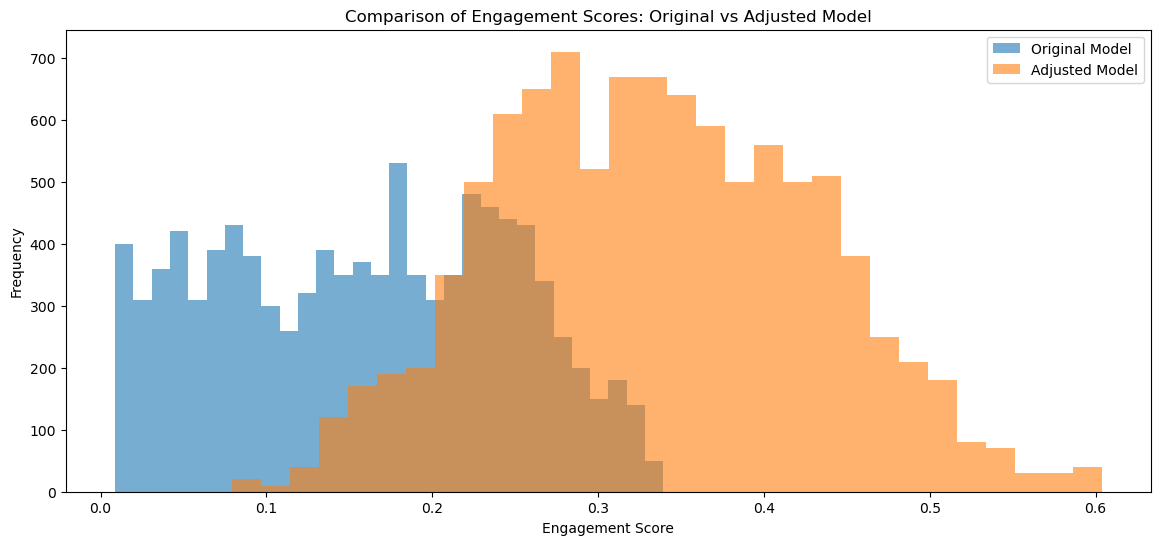

In [ ]:
# Re-define the function to run A/B testing for campaign effectiveness
def run_ab_testing_for_campaign_effectiveness(data, num_iterations=10):
    # Initialize models for original and adjusted strategies
    original_model = ModifiedBanditWithSGD(n_arms=3)  # Original model
    adjusted_model = MainOptimizer(n_arms=3, alpha=0.5, beta=0.7)  # Adjusted model using RFM score

    original_engagement_scores = []
    adjusted_engagement_scores = []

    # Feature columns used for customer input
    feature_columns = ['Customer_Age', 'Gender', 'Num_of_Contacts_Made', 'Financial_Status', 'Total_Trans_Count',
                       'Savings', 'Total_Trans_Amt', 'Balance', 'Credit_Score', 'Outstanding_Loans']

    for _ in range(num_iterations):
        for _, row in data.iterrows():
            customer_features = row[feature_columns].values
            rfm_score = row['engagement_score']  # RFM score for adjusted model

            # Original model strategy
            chosen_arm_original = original_model.select_arm(customer_features)
            original_conversion_rate = row['conversion_rate']
            original_clickthrough_rate = row['clickthrough_rate']
            original_score = 0.7 * original_conversion_rate + 0.3 * original_clickthrough_rate
            original_engagement_scores.append(original_score)
            original_model.update(chosen_arm_original, customer_features, original_conversion_rate, original_clickthrough_rate)

            # Adjusted model strategy
            chosen_arm_adjusted = adjusted_model.select_arm(customer_features)
            adjusted_conversion_rate = row['conversion_rate']
            adjusted_clickthrough_rate = row['clickthrough_rate']
            adjusted_score = adjusted_model.alpha * (adjusted_model.beta * adjusted_conversion_rate + 
                                                     (1 - adjusted_model.beta) * adjusted_clickthrough_rate) + \
                             (1 - adjusted_model.alpha) * rfm_score
            adjusted_engagement_scores.append(adjusted_score)
            adjusted_model.update(chosen_arm_adjusted, customer_features, adjusted_conversion_rate, 
                                  adjusted_clickthrough_rate, rfm_score)

    # Calculate and print average engagement scores
    avg_original_engagement = np.mean(original_engagement_scores)
    avg_adjusted_engagement = np.mean(adjusted_engagement_scores)

    print(f"Average Engagement Score - Original Model: {avg_original_engagement:.3f}")
    print(f"Average Engagement Score - Adjusted Model: {avg_adjusted_engagement:.3f}")

    # Visualize comparison of engagement scores
    plt.figure(figsize=(14, 6))
    plt.hist(original_engagement_scores, bins=30, alpha=0.6, label='Original Model')
    plt.hist(adjusted_engagement_scores, bins=30, alpha=0.6, label='Adjusted Model')
    plt.title('Comparison of Engagement Scores: Original vs Adjusted Model')
    plt.xlabel('Engagement Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Run the A/B testing with the generated synthetic data
run_ab_testing_for_campaign_effectiveness(full_synthetic_data, num_iterations=10)


**Model Evaluation**
We succeed in improve our model. This is because that Adjusted Model has advantage in taking consideration of historical and recency data, allowing model to more comprehensively capture the customers' preference.

#### 4. **Add-on Feature**
- while adjusting parameters such as offering size discount are currently infeasible based on our technical complexity, we actually can adjust the CashBack Parameters to find a balance point between ROI and conversion rate

#### **Part II: Optimizers for cashback**

In [46]:
class SegmentedCashbackOptimizer:
    def __init__(self, initial_thresholds, min_threshold=1000, max_threshold=5000, adjustment_step=100):
        # Independent thresholds for different financial statuses
        self.thresholds = initial_thresholds  # e.g., {'High': 4000, 'Moderate': 3000, 'Low': 2000}
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold
        self.adjustment_step = adjustment_step

    def calculate_roi(self, total_revenue, total_cost):
        """
        Calculate the ROI given total revenue and total cost.
        """
        return total_revenue / total_cost if total_cost > 0 else 0

    def adjust_threshold(self, financial_status, conversion_rate, current_roi, target_roi=1.2):
        """
        Adjust the cashback threshold for a specific financial status based on conversion rate and ROI.
        """
        current_threshold = self.thresholds[financial_status]
        if current_roi < target_roi and conversion_rate > 0.1:  # High conversion but low ROI
            # Increase the threshold to reduce cost
            new_threshold = min(current_threshold + self.adjustment_step, self.max_threshold)
        elif current_roi >= target_roi and conversion_rate < 0.05:  # Low conversion but good ROI
            # Decrease the threshold to attract more customers
            new_threshold = max(current_threshold - self.adjustment_step, self.min_threshold)
        else:
            new_threshold = current_threshold  # No change if within acceptable ranges

        self.thresholds[financial_status] = new_threshold
        return new_threshold


#### **Simulation for CashBack Optimizer**

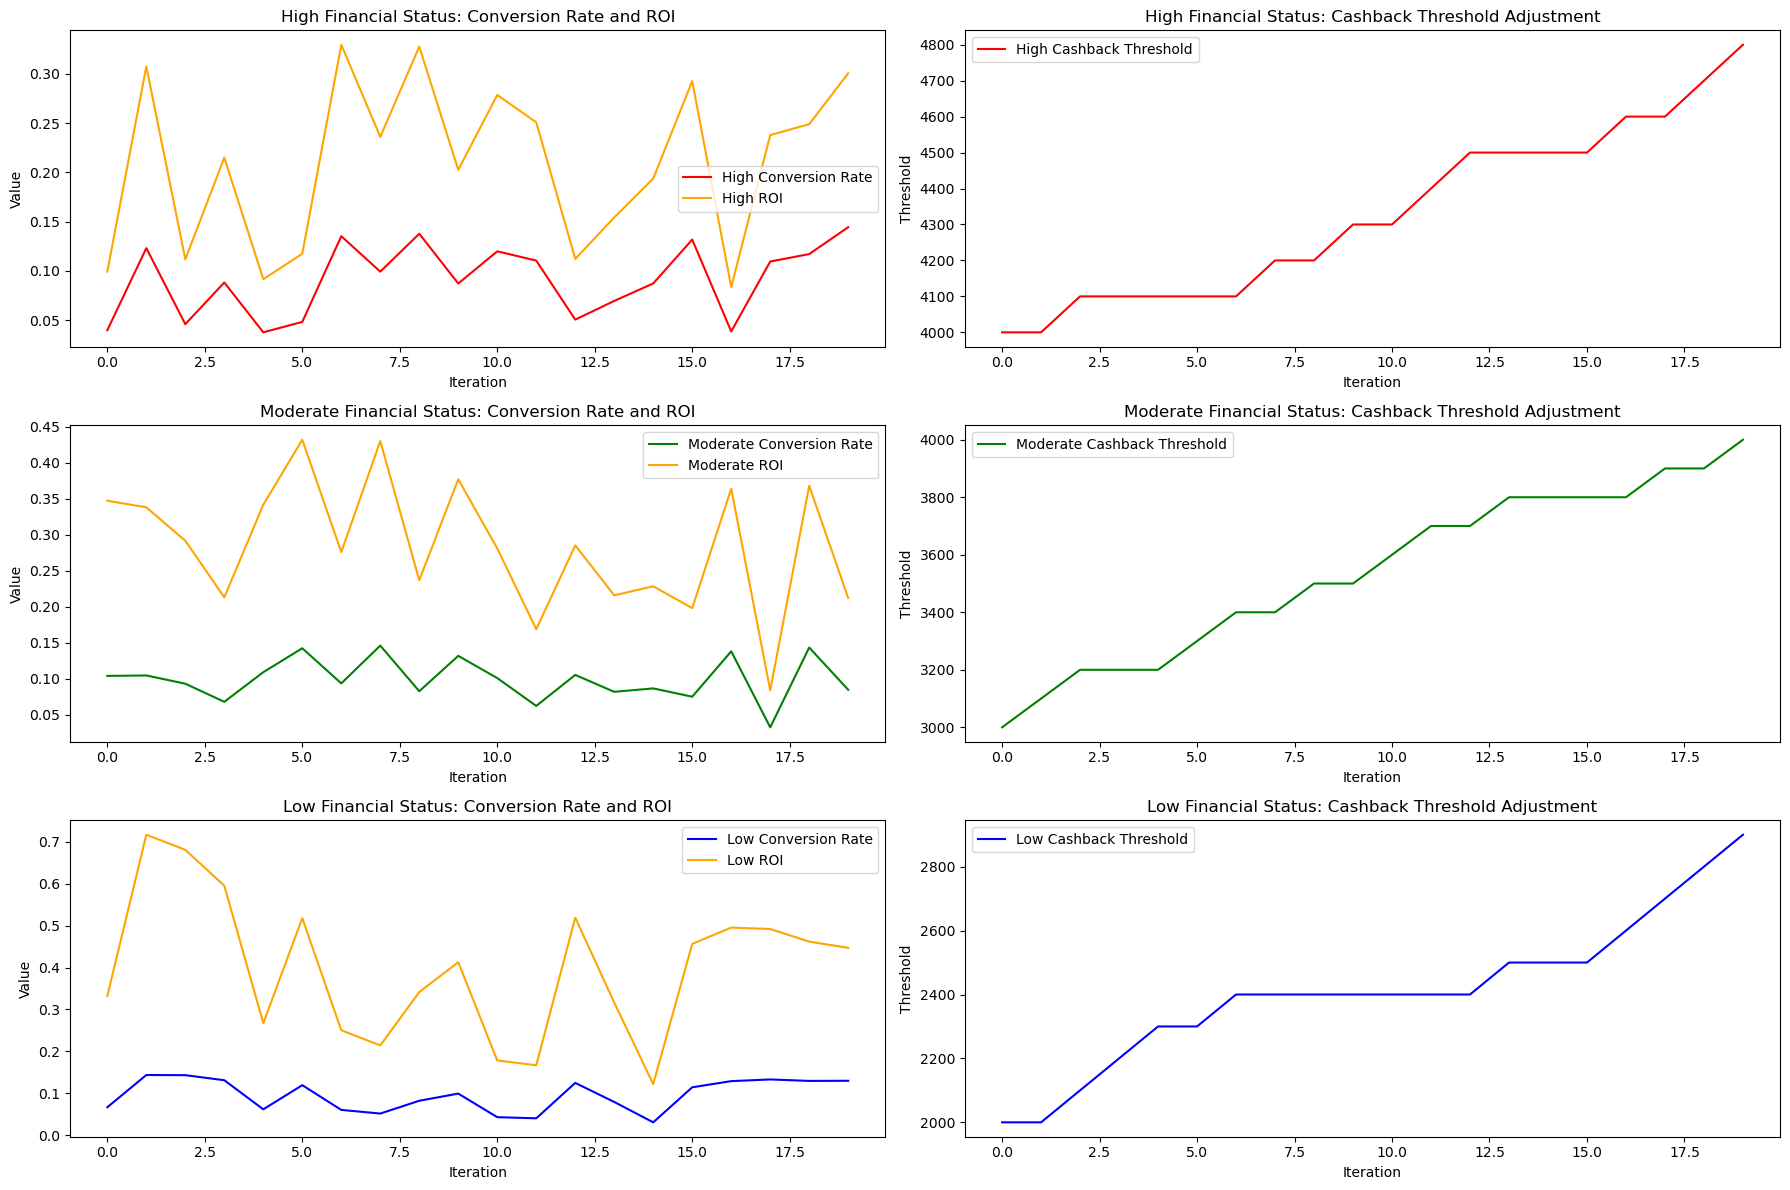

In [38]:
# Initialize the segmented optimizer with starting thresholds
initial_thresholds = {'High': 4000, 'Moderate': 3000, 'Low': 2000}
segmented_optimizer = SegmentedCashbackOptimizer(initial_thresholds)

# Simulate data for each financial status segment
iterations = 20
financial_statuses = ['High', 'Moderate', 'Low']
roi_values_segmented = {status: [] for status in financial_statuses}
conversion_rates_segmented = {status: [] for status in financial_statuses}
threshold_values_segmented = {status: [] for status in financial_statuses}

# Simulate the adjustment process for each financial status
for i in range(iterations):
    for status in financial_statuses:
        # Simulate fluctuating conversion rates for each status
        conversion_rate = np.random.uniform(0.03, 0.15)
        total_revenue = 50000 * conversion_rate  # Simulated revenue
        total_cost = segmented_optimizer.thresholds[status] * 0.05 * 100  # Assume 5% of the cashback threshold

        # Calculate current ROI
        current_roi = segmented_optimizer.calculate_roi(total_revenue, total_cost)

        # Store results for analysis
        roi_values_segmented[status].append(current_roi)
        conversion_rates_segmented[status].append(conversion_rate)
        threshold_values_segmented[status].append(segmented_optimizer.thresholds[status])

        # Adjust the threshold for the next iteration
        segmented_optimizer.adjust_threshold(status, conversion_rate, current_roi)

# Plot the results for each financial status
plt.figure(figsize=(18, 12))
colors = {'High': 'red', 'Moderate': 'green', 'Low': 'blue'}

for i, status in enumerate(financial_statuses, 1):
    plt.subplot(3, 2, i * 2 - 1)
    plt.plot(range(iterations), conversion_rates_segmented[status], label=f"{status} Conversion Rate", color=colors[status])
    plt.plot(range(iterations), roi_values_segmented[status], label=f"{status} ROI", color='orange')
    plt.title(f"{status} Financial Status: Conversion Rate and ROI")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()

    plt.subplot(3, 2, i * 2)
    plt.plot(range(iterations), threshold_values_segmented[status], label=f"{status} Cashback Threshold", color=colors[status])
    plt.title(f"{status} Financial Status: Cashback Threshold Adjustment")
    plt.xlabel("Iteration")
    plt.ylabel("Threshold")
    plt.legend()

plt.tight_layout()
plt.show()


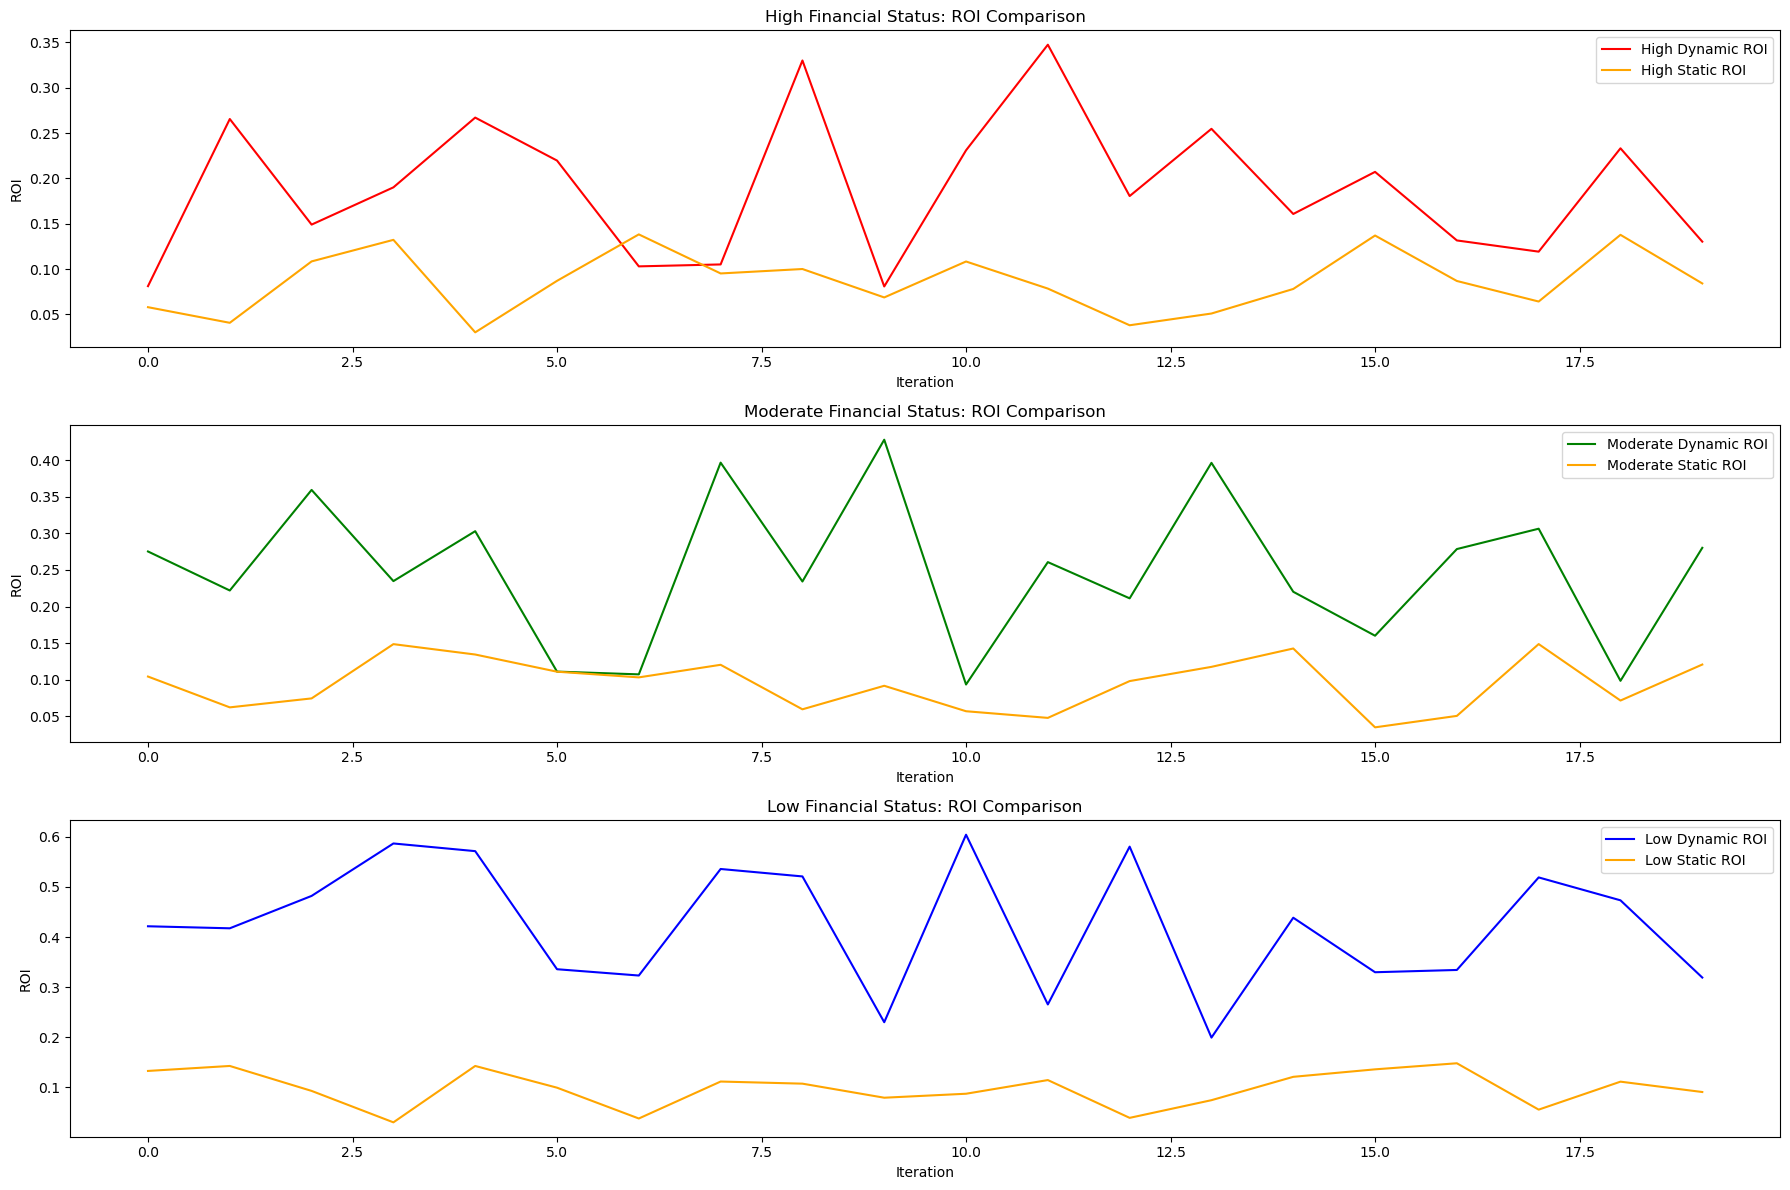

In [ ]:
# Static strategy offers for comparison
static_offers = {
    'High': {'threshold': 4000, 'cashback': 200},
    'Moderate': {'threshold': 3000, 'cashback': 100},
    'Low': {'threshold': 2000, 'cashback': 100}
}

# Function to simulate static strategy performance
def static_strategy_performance(financial_status, conversion_rate):
    offer = static_offers[financial_status]
    threshold = offer['threshold']
    cashback = offer['cashback']
    total_cost = cashback * 100  # Assume 100 customers are offered the cashback
    total_revenue = conversion_rate * total_cost  # Simulated revenue based on conversion rate
    roi = total_revenue / total_cost if total_cost > 0 else 0
    return roi

# Simulate data for comparison
static_roi_values = {status: [] for status in financial_statuses}

# Run the simulation for both dynamic and static strategies
for i in range(iterations):
    for status in financial_statuses:
        # Simulate fluctuating conversion rates
        conversion_rate = np.random.uniform(0.03, 0.15)

        # Dynamic strategy (already calculated earlier)
        current_roi_dynamic = roi_values_segmented[status][i]  # Using the previously stored data

        # Static strategy ROI calculation
        roi_static = static_strategy_performance(status, conversion_rate)
        static_roi_values[status].append(roi_static)

# Plot the comparison between dynamic and static strategies
plt.figure(figsize=(18, 12))

for i, status in enumerate(financial_statuses, 1):
    plt.subplot(3, 1, i)
    plt.plot(range(iterations), roi_values_segmented[status], label=f"{status} Dynamic ROI", color=colors[status])
    plt.plot(range(iterations), static_roi_values[status], label=f"{status} Static ROI", color='orange')
    plt.title(f"{status} Financial Status: ROI Comparison")
    plt.xlabel("Iteration")
    plt.ylabel("ROI")
    plt.legend()

plt.tight_layout()
plt.show()


**We achieved in attaininng higher ROI**